[View in Colaboratory](https://colab.research.google.com/github/JohannesFerner/playing-with-tensorflow/blob/master/first.ipynb)

# Data-Preparation for Predicting Bitcoin Price Movements


In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

!pip install -q ta
from ta import *
import timeit



## Goals of this Notebook


*   Import Bitcoin price data
*   Clean Data (**TODO!**)
  *   Resample to 5min data
  *   Add Technical Indicators
  *   Clean out "useless" features  (**TODO!**)
  *   Add calculated Labels to Data (**TODO!**)
*   Split in Train+Test Data
*   Download Data




## Download, Unzip, Investigate
Following section downloads the 1min BTC Data from my github Repository, unzips, converts to a dataframe and performs a first visualization of the data

In [0]:
# Get the data (stored at my github repository)
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
# or: requests.get(url).content

resp = urlopen('https://raw.githubusercontent.com/JohannesFerner/playing-with-tensorflow/master/data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv.zip')
zipfile = ZipFile(BytesIO(resp.read()))
filenames = zipfile.namelist()

In [137]:
# Seperate code-container, to be easy on github traffic
df = pd.read_csv(zipfile.open(filenames[0]))
# Convert Unix Timestamp to DateTime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Data Exploration
df.info()

print('First Data')
df.head()

print('Latest Data')
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273377 entries, 0 to 3273376
Data columns (total 8 columns):
Timestamp            datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 199.8 MB
First Data
Latest Data


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
3273372,2018-03-26 23:56:00,8159.21,8159.39,8153.62,8153.68,0.663192,5408.215377,8154.826880
3273373,2018-03-26 23:57:00,8159.38,8163.72,8152.81,8155.00,3.720024,30333.753144,8154.182788
3273374,2018-03-26 23:58:00,8157.47,8158.60,8130.01,8130.01,27.294436,222388.761970,8147.769162
3273375,2018-03-26 23:59:00,8145.17,8149.66,8130.01,8149.66,23.065281,187570.784940,8132.169837
3273376,2018-03-27 00:00:00,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220


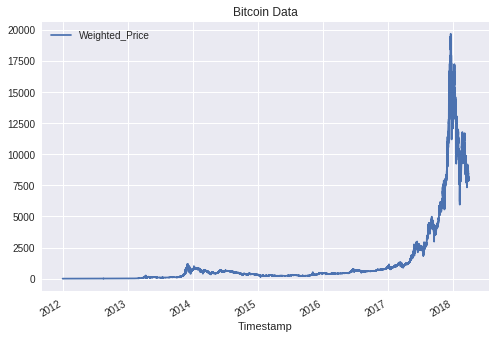

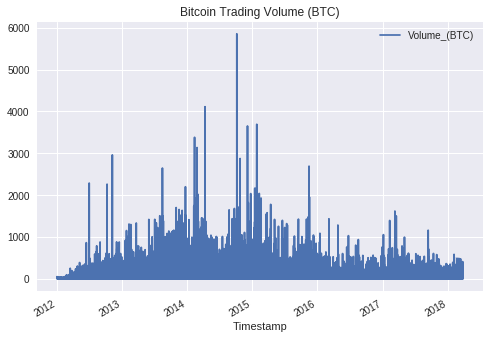

In [138]:
df.plot(y='Weighted_Price', x='Timestamp', title='Bitcoin Data')
df.plot(y='Volume_(BTC)', x='Timestamp', title='Bitcoin Trading Volume (BTC)')

# Data-Preparation 

the following sections shrink the used dataset to 2017 onwards, performs technical indicator calculations, performs label calculations

In [0]:
#1483228800 = 2017-01-01 00:00

bitcoindata = df.loc[2625376::]
del df #safe some memory


In [140]:
bitcoindata.all()

Timestamp             True
Open                  True
High                  True
Low                   True
Close                 True
Volume_(BTC)         False
Volume_(Currency)    False
Weighted_Price        True
dtype: bool

In [141]:
# Resampling 1min OHLC to 5min OHLC Data
bitcoindata.tail()
bitcoindata['Timestamp']  = pd.to_datetime(bitcoindata['Timestamp'], unit='s')
bitcoindata           = bitcoindata.set_index('Timestamp')

bitcoindata = bitcoindata.resample('5Min').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume_(BTC)': 'sum',
        'Volume_(Currency)': 'sum',
        'Weighted_Price': 'mean' 
})
bitcoindata.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-03-26 23:40:00,8177.43,8177.43,8159.00,8164.00,22.545058,184115.242660,8165.590242
2018-03-26 23:45:00,8164.08,8183.66,8164.04,8165.59,18.523917,151385.461390,8169.734965
2018-03-26 23:50:00,8165.04,8172.18,8157.83,8168.00,5.829670,47627.130417,8167.852025
2018-03-26 23:55:00,8167.70,8168.00,8130.01,8149.66,55.374303,450858.105146,8151.249566
2018-03-27 00:00:00,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220


## Add Technical Indicators
https://github.com/bukosabino/ta package used

In [142]:
bitcoindata = add_all_ta_features(bitcoindata, "Open", "High", "Low", "Close", "Volume_(BTC)",
                                fillna=True)
bitcoindata.head()
bitcoindata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129601 entries, 2017-01-01 00:00:00 to 2018-03-27 00:00:00
Freq: 5T
Data columns (total 55 columns):
Open                 129601 non-null float64
High                 129601 non-null float64
Low                  129601 non-null float64
Close                129601 non-null float64
Volume_(BTC)         129601 non-null float64
Volume_(Currency)    129601 non-null float64
Weighted_Price       129601 non-null float64
volume1              129601 non-null float64
volume2              129601 non-null float64
volume3              129601 non-null float64
volume5              129601 non-null float64
volume6              129601 non-null float64
volume7              129601 non-null float64
volume8              129601 non-null float64
volatility1          129601 non-null float64
volatility2          129601 non-null float64
volatility3          129601 non-null float64
volatility4          129601 non-null float64
volatility5          129601 non-null

In [0]:
fillna = True
#correct naming of indicators
bitcoindata.rename(columns={'volume1': 'acc_dist_index', 
                   'volume2': 'on_balance_volume', 
                   'volume3': 'on_balance_volume_mean',
                   'volume5': 'chaikin_money_flow',
                   'volume6': 'force_index',
                   'volume7': 'ease_of_movement',
                   'volume8': 'volume_price_trend',
                   'volatility1': 'average_true_range', 
                   'volatility2': 'bollinger_hband',
                   'volatility3': 'bollinger_lband',
                   'volatility4': 'bollinger_mavg',
                   'volatility5': 'bollinger_hband_indicator',
                   'volatility6': 'bollinger_lband_indicator',
                   'volatility7': 'keltner_channel_central',
                   'volatility8': 'keltner_channel_hband',
                   'volatility9': 'keltner_channel_lband',
                   'volatility10': 'keltner_channel_hband_indicator',
                   'volatility11': 'keltner_channel_lband_indicator',
                   'volatility12': 'donchian_channel_hband',
                   'volatility13': 'donchian_channel_lband',
                   'volatility14': 'donchian_channel_hband_indicator',
                   'volatility15': 'donchian_channel_lband_indicator',
                   'trend1': 'macd',
                   'trend2': 'macd_signal',
                   'trend3': 'macd_diff',
                   'trend4': 'ema_fast',
                   'trend5': 'ema_slow',
                   'trend6': 'adx',
                   'trend7': 'adx_pos',
                   'trend8': 'adx_neg',
                   'trend9': 'adx_indicator',
                   'trend10': 'vortex_indicator_pos',
                   'trend11': 'vortex_indicator_neg',
                   'trend12': 'vortex_diff',
                   'trend13': 'trix',
                   'trend14': 'mass_index',
                   'trend15': 'cci',
                   'trend16': 'dpo',
                   'trend17': 'kst',
                   'trend18': 'kst_sig',
                   'trend19': 'kst_diff',
                   'trend20': 'ichimoku_a',
                   'trend21': 'ichimoku_b',
                   'momentum1': 'rsi',
                   'momentum2': 'money_flow_index',
                   'momentum3': 'tsi',
                   'others1': 'daily_return',
                   'others2': 'cumulative_return'},
          
          
          inplace=True)


In [144]:
bitcoindata.tail()


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,acc_dist_index,on_balance_volume,on_balance_volume_mean,...,kst,kst_sig,kst_diff,ichimoku_a,ichimoku_b,rsi,money_flow_index,tsi,daily_return,cumulative_return
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-26 23:40:00,8177.43,8177.43,8159.00,8164.00,22.545058,184115.242660,8165.590242,6.857083,-22.545058,-12.117487,...,30.014980,32.344699,-2.329719,7894.5750,7910.150,57.759505,36.408039,24.877359,-0.184617,744.810994
2018-03-26 23:45:00,8164.08,8183.66,8164.04,8165.59,18.523917,151385.461390,8169.734965,-25.909355,18.523917,-9.237710,...,28.204257,32.013091,-3.808834,7894.5750,7910.150,57.981718,39.923415,24.457875,0.019476,744.975527
2018-03-26 23:50:00,8165.04,8172.18,8157.83,8168.00,5.829670,47627.130417,8167.852025,-13.163670,5.829670,-7.561042,...,26.434871,31.372794,-4.937923,7894.4700,7910.150,58.337650,37.427687,24.111188,0.029514,745.224914
2018-03-26 23:55:00,8167.70,8168.00,8130.01,8149.66,55.374303,450858.105146,8151.249566,4.342889,-55.374303,-14.582705,...,24.484323,30.436843,-5.952519,7886.5325,7910.150,54.568721,27.074148,23.468574,-0.224535,743.327090
2018-03-27 00:00:00,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220,-11.392461,17.758130,-14.084148,...,22.088721,29.144572,-7.055852,7885.3675,7900.065,55.140989,35.295083,22.931632,0.041474,743.676853


In [145]:
bitcoindata.drop(columns=['cumulative_return']) # not used in further prediction models


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,acc_dist_index,on_balance_volume,on_balance_volume_mean,...,dpo,kst,kst_sig,kst_diff,ichimoku_a,ichimoku_b,rsi,money_flow_index,tsi,daily_return
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,966.20,966.37,966.16,966.37,33.876213,3.273492e+04,966.301459,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,964.2325,963.760,50.000000,50.000000,0.000000,0.000000
2017-01-01 00:05:00,966.43,966.58,966.43,966.58,1.433930,1.385992e+03,966.550000,35.310143,1.433930,0.000000,...,0.0000,0.000000,0.000000,0.000000,964.2325,963.760,100.000000,50.000000,100.000000,0.021731
2017-01-01 00:10:00,966.57,966.57,964.60,965.55,6.661770,6.433273e+03,965.888343,1.197217,-6.661770,0.000000,...,0.0000,0.000000,0.000000,0.000000,964.2325,963.760,15.986949,50.000000,-27.599762,-0.106561
2017-01-01 00:15:00,965.59,966.57,965.55,965.55,21.128869,2.041402e+04,965.853382,-21.365582,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,964.2325,963.760,15.986949,50.000000,-41.442352,0.000000
2017-01-01 00:20:00,965.60,966.54,964.87,964.87,0.804923,7.772682e+02,965.891048,-21.933793,-0.804923,0.000000,...,0.0000,0.000000,0.000000,0.000000,964.2325,963.760,9.767707,50.000000,-53.094749,-0.070426
2017-01-01 00:25:00,966.54,966.54,964.87,965.24,8.723552,8.420425e+03,965.263680,-5.662949,8.723552,0.000000,...,0.0000,0.000000,0.000000,0.000000,964.2325,963.760,26.448587,50.000000,-51.911351,0.038347
2017-01-01 00:30:00,965.26,965.26,965.24,965.24,34.400000,3.320452e+04,965.247567,-39.258026,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,964.2325,963.760,26.448587,50.000000,-51.256448,0.000000
2017-01-01 00:35:00,966.37,966.40,966.06,966.39,6.253563,6.043370e+03,966.354399,-28.514294,6.253563,0.000000,...,0.0000,0.000000,0.000000,0.000000,964.2325,963.760,55.681195,50.000000,-39.712997,0.119141
2017-01-01 00:40:00,966.39,966.40,966.38,966.38,20.703929,2.000817e+04,966.391829,-14.818223,-20.703929,0.000000,...,0.0000,0.000000,0.000000,0.000000,964.2325,963.760,55.475774,50.000000,-32.541993,-0.001035


## Add Labels to Data

As this data is intented to be used in a classification ML Model which should predict the possibility of a certain price-movement in percent-ranges this features have to be calculated on the historical data

In [146]:
firstIndex = bitcoindata.first_valid_index()

#Labels to Add: 
# Boolean: WentUp
# Boolean: Neutral
# Boolean: WentDown
# pctOpenChangePeriod
# pctHighChangePeriod
# pctLowChangePeriod
# pctCloseChangePeriod
# Boolean: touched 1-3%
# Boolean: touched 3-5%
# Boolean: touched 5-10%
# Boolean: touched 10%plus
# Boolean: touched minus 1-3%
# Boolean: touched minus 3-5%
# Boolean: touched minus 5-10%
# Boolean: touched minus 10%plus
LOOKAHEAD = -6 # look 6*5mins ahead


bitcoindata['pctOpenChangePeriod'] = bitcoindata['Open'].pct_change(periods=LOOKAHEAD) *100
bitcoindata['pctHighChangePeriod'] = bitcoindata['High'].pct_change(periods=LOOKAHEAD) *100
bitcoindata['pctLowChangePeriod'] = bitcoindata['Low'].pct_change(periods=LOOKAHEAD) *100
bitcoindata['pctCloseChangePeriod'] = bitcoindata['Close'].pct_change(periods=LOOKAHEAD) *100


print(bitcoindata['pctCloseChangePeriod'].describe())
bitcoindata['positiveMaxPctChange'] =bitcoindata[["pctOpenChangePeriod", "pctHighChangePeriod", "pctLowChangePeriod", "pctCloseChangePeriod"]].max(axis=1) 
bitcoindata['negativeMaxPctChange'] =bitcoindata[["pctOpenChangePeriod", "pctHighChangePeriod", "pctLowChangePeriod", "pctCloseChangePeriod"]].min(axis=1) 

bitcoindata['touched1-3%'] = (bitcoindata['positiveMaxPctChange'] > 1) & (bitcoindata['positiveMaxPctChange'] < 3)
bitcoindata['touched3-5%'] = (bitcoindata['positiveMaxPctChange'] > 3) & (bitcoindata['positiveMaxPctChange'] < 5)
bitcoindata['touched5-10%'] = (bitcoindata['positiveMaxPctChange'] > 5) & (bitcoindata['positiveMaxPctChange'] < 10)
bitcoindata['touched10%plus'] = (bitcoindata['positiveMaxPctChange'] > 10) & (bitcoindata['positiveMaxPctChange'] < 3)

bitcoindata['touchedMinus1-3%'] = (bitcoindata['negativeMaxPctChange'] < -1) & (bitcoindata['negativeMaxPctChange'] > -3)
bitcoindata['touchedMinus3-5%'] = (bitcoindata['negativeMaxPctChange'] < -3) & (bitcoindata['negativeMaxPctChange'] > -5)
bitcoindata['touchedMinus5-10%'] = (bitcoindata['negativeMaxPctChange'] < -5) & (bitcoindata['negativeMaxPctChange'] > -10)
bitcoindata['touchedMinus10%plus'] = (bitcoindata['negativeMaxPctChange'] < -10) & (bitcoindata['negativeMaxPctChange'] > -3)


print(bitcoindata.describe())
bitcoindata[firstIndex::]


count    129595.000000
mean         -0.006124
std           0.869130
min         -10.547097
25%          -0.365157
50%          -0.023260
75%           0.311963
max          22.544356
Name: pctCloseChangePeriod, dtype: float64
                Open           High            Low          Close  \
count  129601.000000  129601.000000  129601.000000  129601.000000   
mean     5213.928122    5227.253744    5198.991452    5213.926170   
std      4517.759555    4532.090749    4501.406615    4517.641219   
min       755.000000     757.330000     751.340000     755.000000   
25%      1270.500000    1272.150000    1269.130000    1270.860000   
50%      3597.180000    3609.690000    3586.050000    3596.760000   
75%      8279.770000    8300.000000    8256.650000    8278.910000   
max     19665.760000   19666.000000   19631.000000   19665.750000   

        Volume_(BTC)  Volume_(Currency)  Weighted_Price  acc_dist_index  \
count  129601.000000       1.296010e+05   129601.000000   129601.000000   
m

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,acc_dist_index,on_balance_volume,on_balance_volume_mean,...,positiveMaxPctChange,negativeMaxPctChange,touched1-3%,touched3-5%,touched5-10%,touched10%plus,touchedMinus1-3%,touchedMinus3-5%,touchedMinus5-10%,touchedMinus10%plus
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,966.20,966.37,966.16,966.37,33.876213,3.273492e+04,966.301459,0.000000,0.000000,0.000000,...,0.117069,0.095313,False,False,False,False,False,False,False,False
2017-01-01 00:05:00,966.43,966.58,966.43,966.58,1.433930,1.385992e+03,966.550000,35.310143,1.433930,0.000000,...,0.038300,0.006209,False,False,False,False,False,False,False,False
2017-01-01 00:10:00,966.57,966.57,964.60,965.55,6.661770,6.433273e+03,965.888343,1.197217,-6.661770,0.000000,...,0.018626,-0.184193,False,False,False,False,False,False,False,False
2017-01-01 00:15:00,965.59,966.57,965.55,965.55,21.128869,2.041402e+04,965.853382,-21.365582,0.000000,0.000000,...,-0.040375,-0.146850,False,False,False,False,False,False,False,False
2017-01-01 00:20:00,965.60,966.54,964.87,964.87,0.804923,7.772682e+02,965.891048,-21.933793,-0.804923,0.000000,...,-0.044469,-0.217173,False,False,False,False,False,False,False,False
2017-01-01 00:25:00,966.54,966.54,964.87,965.24,8.723552,8.420425e+03,965.263680,-5.662949,8.723552,0.000000,...,-0.044469,-0.177945,False,False,False,False,False,False,False,False
2017-01-01 00:30:00,965.26,965.26,965.24,965.24,34.400000,3.320452e+04,965.247567,-39.258026,0.000000,0.000000,...,-0.138630,-0.140699,False,False,False,False,False,False,False,False
2017-01-01 00:35:00,966.37,966.40,966.06,966.39,6.253563,6.043370e+03,966.354399,-28.514294,6.253563,0.000000,...,0.135740,-0.023795,False,False,False,False,False,False,False,False
2017-01-01 00:40:00,966.39,966.40,966.38,966.38,20.703929,2.000817e+04,966.391829,-14.818223,-20.703929,0.000000,...,0.398944,0.031053,False,False,False,False,False,False,False,False


# Split in Train Test

Split Data into 70% Test, 30% Test and visualize in order to detect problems easily (Hint: ``` shuffle=False ```)


In [0]:


from sklearn.model_selection import train_test_split

# Split Data into 70% Test, 30% Test
train, test = train_test_split(bitcoindata, test_size=0.3, shuffle=False) 


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,acc_dist_index,on_balance_volume,on_balance_volume_mean,...,positiveMaxPctChange,negativeMaxPctChange,touched1-3%,touched3-5%,touched5-10%,touched10%plus,touchedMinus1-3%,touchedMinus3-5%,touchedMinus5-10%,touchedMinus10%plus
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-26 23:40:00,8177.43,8177.43,8159.00,8164.00,22.545058,184115.242660,8165.590242,6.857083,-22.545058,-12.117487,...,NaN,NaN,False,False,False,False,False,False,False,False
2018-03-26 23:45:00,8164.08,8183.66,8164.04,8165.59,18.523917,151385.461390,8169.734965,-25.909355,18.523917,-9.237710,...,NaN,NaN,False,False,False,False,False,False,False,False
2018-03-26 23:50:00,8165.04,8172.18,8157.83,8168.00,5.829670,47627.130417,8167.852025,-13.163670,5.829670,-7.561042,...,NaN,NaN,False,False,False,False,False,False,False,False
2018-03-26 23:55:00,8167.70,8168.00,8130.01,8149.66,55.374303,450858.105146,8151.249566,4.342889,-55.374303,-14.582705,...,NaN,NaN,False,False,False,False,False,False,False,False
2018-03-27 00:00:00,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220,-11.392461,17.758130,-14.084148,...,NaN,NaN,False,False,False,False,False,False,False,False


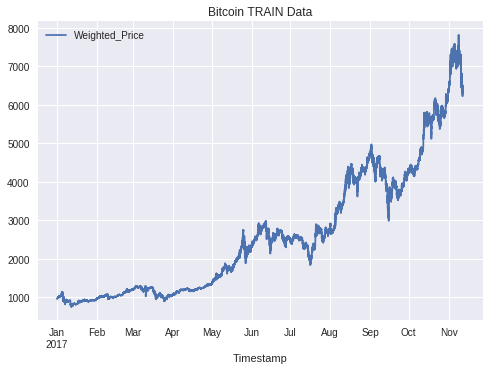

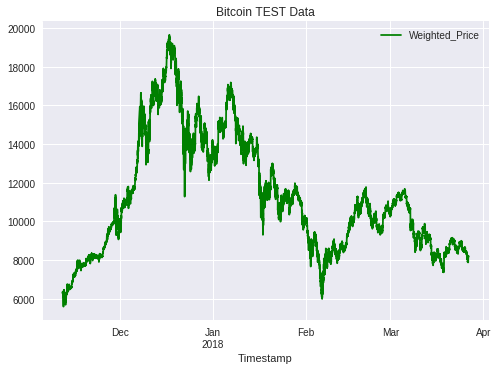

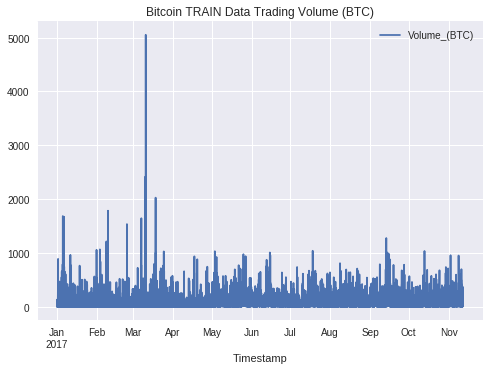

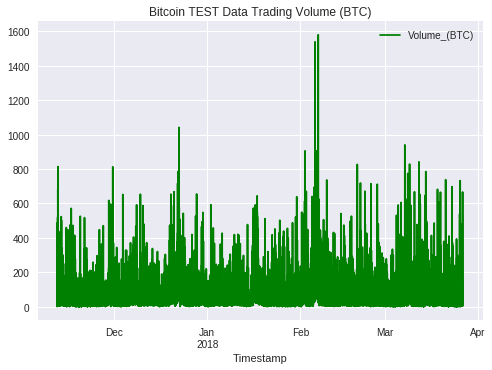

In [148]:
#Visualization is a good idea, i didn't know about the train_test_split shuffle parameter before

train.plot(y='Weighted_Price', title='Bitcoin TRAIN Data')
test.plot(y='Weighted_Price', title='Bitcoin TEST Data', color='g')

train.plot(y='Volume_(BTC)', title='Bitcoin TRAIN Data Trading Volume (BTC)')
test.plot(y='Volume_(BTC)', title='Bitcoin TEST Data Trading Volume (BTC)', color='g')


test.tail()

# Download Data

The following section will zip the train and test data as CSV and provide a download 

In [0]:
from google.colab import files
!mkdir data
bitcoindata.to_csv('data/allData.csv')
test.to_csv('data/test.csv')
train.to_csv('data/train.csv')
import shutil
shutil.make_archive('data', 'zip', 'data')
files.download('data.zip')


mkdir: cannot create directory ‘data’: File exists
